In [1]:
#%matplotlib notebook
#DEFAULT_FIGSIZE = (8, 6)
%matplotlib inline 
DEFAULT_FIGSIZE = (12, 8)

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from dtk.bicycle import benchmark_state_space_vs_speed, benchmark_matrices
import control

import plot_sim as ps

from phobos import sysid

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

length 50
frequencies 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0
rs sequence 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0


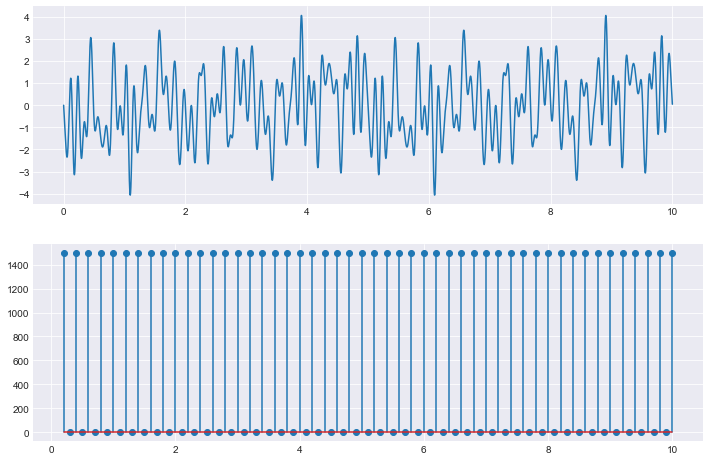

In [2]:
plt.close('all')

t = np.arange(0, 10, 0.001)
dt = 0.001
n = int(10/dt)

def multisine(frequencies):
    n = len(frequencies)
    seq = np.array(sysid.rudin_shapiro(n) > 0).astype(float)
    print('length', n)
    print('frequencies', ', '.join(str(f) for f in frequencies))
    print('rs sequence', ', '.join(str(s) for s in seq))
    
    u = np.zeros(t.shape)
    amplitude = 0.3
    for f, s in zip(frequencies, seq):
        period = 1/f
        u += amplitude*np.sin(2*np.pi*f*t + s*np.pi)
    return u

# we use these later
u_freq = np.arange(0.2, 10.2, 0.2)
u = multisine(u_freq)

x = np.fft.rfft(u)
freq = np.fft.rfftfreq(len(u), dt)
index = (freq >= min(u_freq)) & (freq <= max(u_freq))

fig, ax = plt.subplots(2, 1)
ax[0].plot(t, u)
ax[1].stem(freq[index], np.abs(x[index]))
plt.show()

In [3]:
# simulate model response to multisine 'u'
_, A, B = benchmark_state_space_vs_speed(*benchmark_matrices(), [5])
A = A[0]
B = B[0]
Bi = B[:, [1]] # steer torque
Ci = np.array([[0, 1, 0, 0]]) # steer angle
D = np.array([[0]])

sys = scipy.signal.StateSpace(A, Bi, Ci, D)
tf = scipy.signal.TransferFunction(sys)

# simulate for 20 seconds
lsim_t = np.arange(0, 20, dt)
lsim_u = np.concatenate((u, u))
_, lsim_y, lsim_x = scipy.signal.lsim(sys, lsim_u, lsim_t)

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [4]:
log = ps.ProcessedRecord('logs/multisine.pb.cobs.gz')
log2 = ps.ProcessedRecord('logs/multisine_kp150_kd3.pb.cobs.gz')
log3 = ps.ProcessedRecord('logs/multisine_kp20_kd2.pb.cobs.gz')
logs = [log, log2, log3]

In [5]:
def plot_response(log):
    t = log.t
    u = sysid._get_signal(log, 'u')
    w = sysid._get_signal(log, 'w')
    v = sysid._get_signal(log, 'v')
    r = sysid._get_signal(log, 'r')
    y = sysid._get_signal(log, 'y')
    
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(t, u[0], label=u[1])
    ax[0].plot(t, w[0], label=w[1])
    ax[0].plot(t, v[0], label=v[1])
    ax[0].legend()
    ax[0].set_ylabel('torque [N-m]')
    
    ax[1].plot(t, 180/np.pi * r[0], label=r[1])
    ax[1].plot(t, 180/np.pi * y[0], label=y[1])
    ax[1].legend()
    ax[1].set_ylabel('angle [deg]')
    ax[1].set_xlabel('time [s]')
    return fig, ax

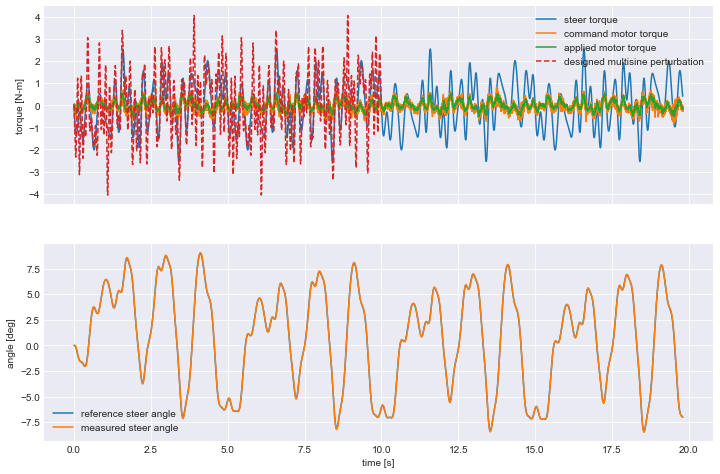

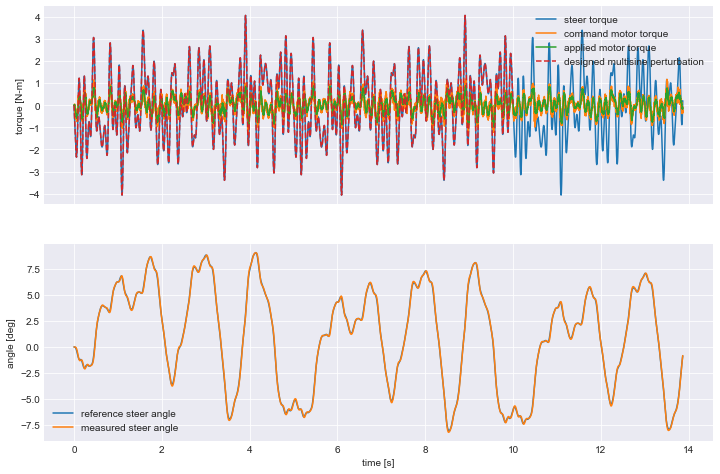

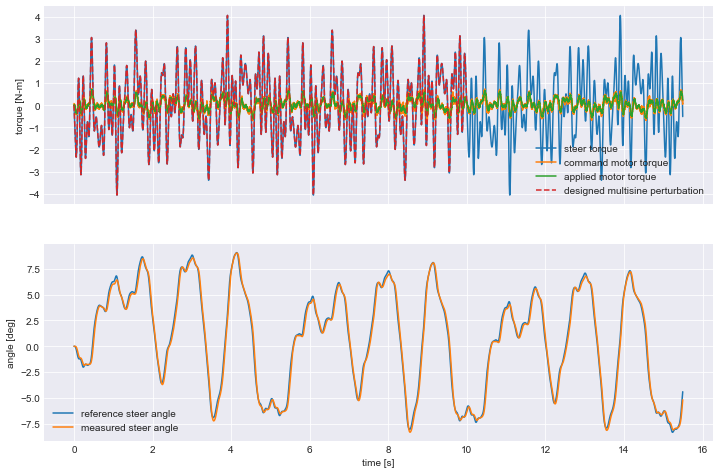

In [6]:
plt.close('all')
for l in logs:
    fig, ax = plot_response(l)
    ax[0].plot(t, u, linestyle='--',
               label='designed multisine perturbation')
    ax[0].legend()
plt.show()

In [7]:
def plot_frequency_response(log, tfio=None, unwrap=True, noverlap=None):
    fig, ax = plt.subplots(3, 1, sharex=True)
    
    if tfio is None: # transfer function input/output list
        tfio = [('u', 'y'), ('r', 'y'), ('u', 'v')]
        
    skipn = int(1//dt) # skip first second
    window_size = n
    print('window size: {}'.format(window_size))
    
    if noverlap is None:
        noverlap = int(n//10)
    
    nwindows = int((len(log.t) - window_size)//noverlap)
    print('plotting frequency response using {} windows with {} overlap'.format(
        nwindows, noverlap))
    
    index = [i for i, f in enumerate(np.around(freq, 1))
             if f in np.around(u_freq, 1)]
    
    for x, y in tfio:
        frf = sysid.frequency_response(x, y, log, skipn, window_size, noverlap)
        c = sysid.coherence(x, y, log, skipn, window_size, noverlap)
        
        x_label = sysid._get_signal(log, x)[1]
        y_label = sysid._get_signal(log, y)[1]
    
        mag = np.abs(frf[index])
        phase = np.angle(frf[index], deg=True)
        if unwrap:
            phase = np.unwrap(phase, 180)
        label='{}/{}: {} to {}'.format(y.upper(), x.upper(), x_label, y_label)
        
        ax[0].loglog(freq[index], mag, label=label)
        ax[1].semilogx(freq[index], phase, label=label)
        ax[2].semilogx(freq[index], c[index], label=label)
    
    ax[0].set_title('frequency response and coherence ({})'.format(log.basename))
    ax[0].legend()
    ax[0].set_ylabel('gain')
    ax[1].legend()
    ax[1].set_ylabel('phase [deg]')
    ax[2].legend()
    ax[2].set_ylabel('coherence')
    ax[2].set_ylim((0, 1))
    return fig, ax

window size: 10000
plotting frequency response using 38 windows with 100 overlap


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


window size: 10000
plotting frequency response using 53 windows with 100 overlap


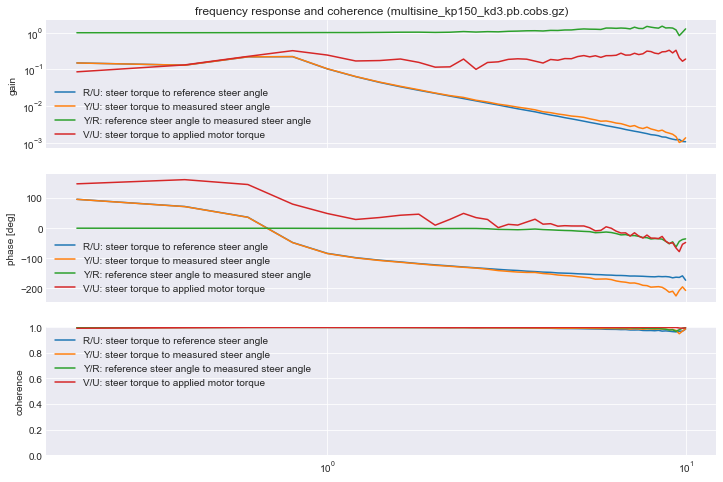

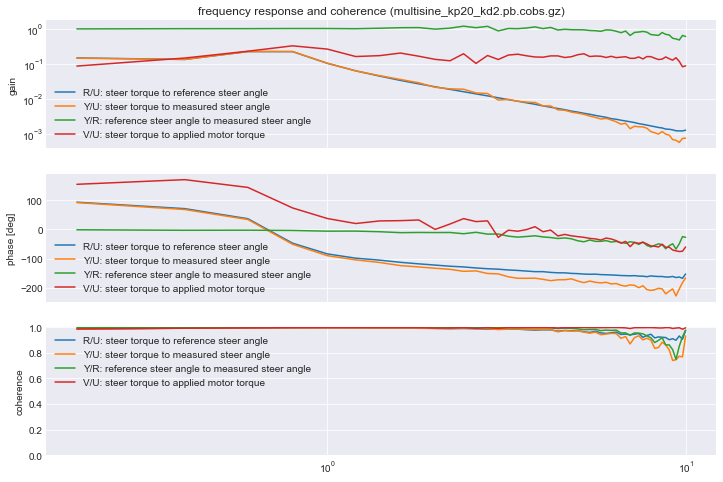

In [8]:
plt.close('all')
for l in logs[1:]:
    plot_frequency_response(
        l, tfio=[('u', 'r'), ('u', 'y'), ('r', 'y'), ('u', 'v')],
        unwrap=True, noverlap=100)
plt.show()

window size: 10000
plotting frequency response using 38 windows with 100 overlap


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


window size: 10000
plotting frequency response using 53 windows with 100 overlap


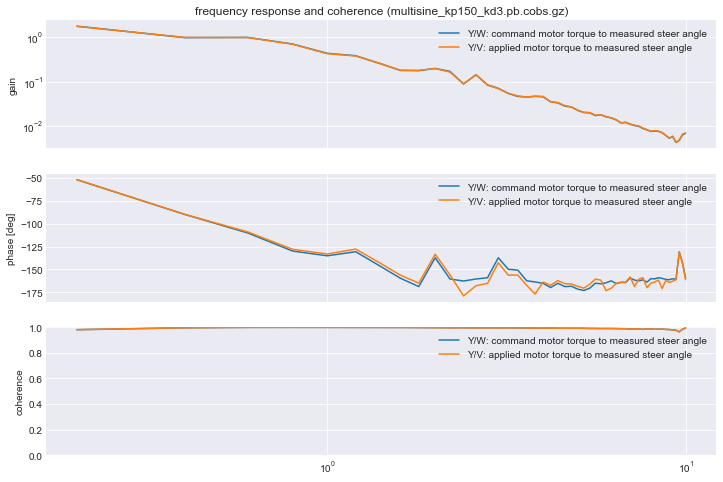

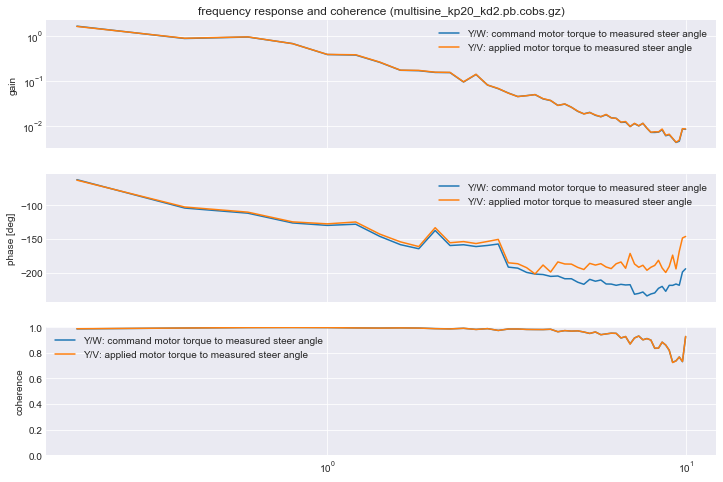

In [9]:
plt.close('all')
for l in logs[1:]:
    plot_frequency_response(
        l, tfio=[('w', 'y'), ('v', 'y')],
        unwrap=True, noverlap=100)
plt.show()